# Predictive Maintenance using LSTM

Credits https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM.

## Setup

Download datasets

In [ ]:
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_test.txt -O PM_test.txt 
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_train.txt -O PM_train.txt  
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_truth.txt -O PM_truth.txt

Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
import os
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Set random seed and dataset / model paths.

In [2]:
np.random.seed(1234)
models_path = './models/'
model_path = models_path + 'regression_model.h5'
data_path = './data/'
train_path = data_path + 'PM_train.txt'
test_path = data_path + 'PM_test.txt'
truth_path = data_path + 'PM_truth.txt'

## Data ingestion

Read training set

In [3]:
columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df = pd.read_csv(train_path, sep=' ', header=None)
train_df.drop(train_df[[26, 27]], axis=1, inplace=True)
train_df.columns = columns
train_df.sort_values(['id', 'cycle'], inplace=True)
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


Read test set and ground truth

In [4]:
test_df = pd.read_csv(test_path, sep=' ', header=None)
test_df.drop(test_df[[26, 27]], axis=1, inplace=True)
test_df.columns = columns
test_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [5]:
truth_df = pd.read_csv(truth_path, sep=' ', header=None)
truth_df.drop(truth_df[[1]], axis=1, inplace=True)
truth_df

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


## Data exploration

We can see the falling trend of sensor 12 during the life of device id==1

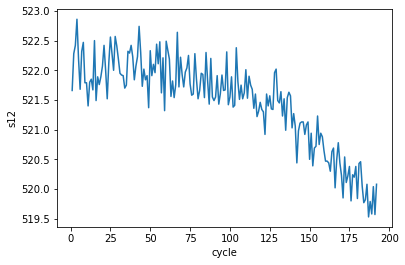

In [6]:
device_id = 1
sns.lineplot(x='cycle', y='s12', data=train_df[train_df['id'] == device_id].drop(['id'], axis=1))

From the boxplots we can see that the data requires normalization

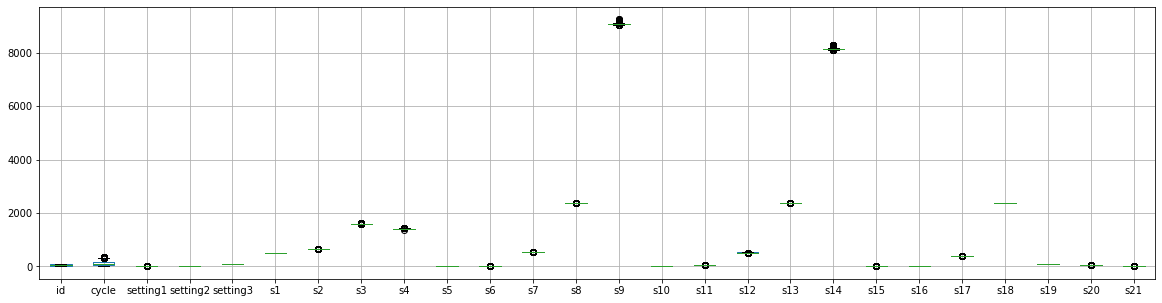

In [8]:
train_df.boxplot(figsize=(20, 5))

In [9]:
train_df.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## Preprocessing


### Train data

First, we need to label the training with the RUL at each cycle

In [14]:
train_rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
train_rul.columns = ['id', 'max']
train_rul

,id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [15]:
train_df = train_df.merge(train_rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,max
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,200
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,200
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,200
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,200


In [16]:
train_df.drop('max', axis=1, inplace=True)
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [17]:
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

Export the MinMaxScaler used on the training set for use in prediction

In [18]:
import joblib 

joblib.dump(min_max_scaler, 'turbofan_scaler.pkl') 

['turbofan_scaler.pkl']

We can see the effect of preprocessing

In [20]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0.000000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0.002770
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0.005540
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0.008310
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,...,0.194344,0.656791,0.0,0.750000,0.0,0.0,0.271318,0.109500,4,0.540166
20627,100,197,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,...,0.188668,0.727203,0.0,0.583333,0.0,0.0,0.124031,0.366197,3,0.542936
20628,100,198,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,...,0.212148,0.922278,0.0,0.833333,0.0,0.0,0.232558,0.053991,2,0.545706
20629,100,199,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,...,0.203065,0.823394,0.0,0.583333,0.0,0.0,0.116279,0.234466,1,0.548476


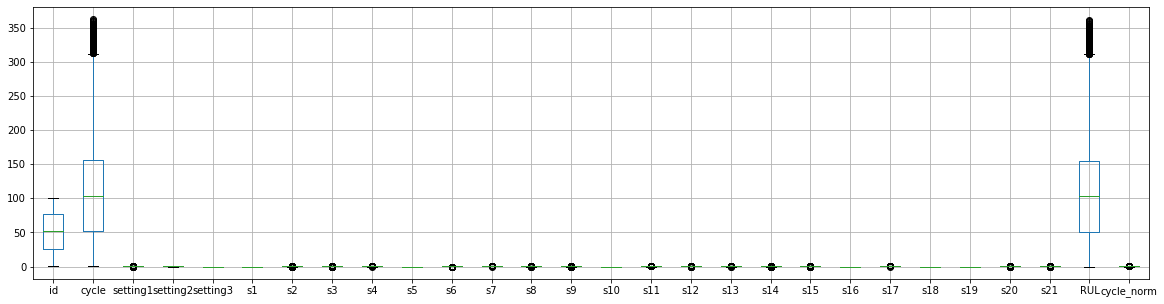

In [21]:
train_df.boxplot(figsize=(20, 5))

In [22]:
train_df.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.0,...,20631.000000,20631.000000,20631.0,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,0.499490,0.501959,0.0,0.0,0.443052,0.424746,0.450435,0.0,...,0.226095,0.451118,0.0,0.434221,0.0,0.0,0.524241,0.546127,107.807862,0.298637
std,29.227633,68.880990,0.125708,0.244218,0.0,0.0,0.150618,0.133664,0.151935,0.0,...,0.098442,0.144306,0.0,0.129064,0.0,0.0,0.140114,0.149476,68.880990,0.190806
min,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,26.000000,52.000000,0.413793,0.333333,0.0,0.0,0.335843,0.331807,0.339467,0.0,...,0.171870,0.346287,0.0,0.333333,0.0,0.0,0.434109,0.452361,51.000000,0.141274
50%,52.000000,104.000000,0.500000,0.500000,0.0,0.0,0.430723,0.415522,0.435348,0.0,...,0.209516,0.438630,0.0,0.416667,0.0,0.0,0.534884,0.557443,103.000000,0.285319
75%,77.000000,156.000000,0.586207,0.750000,0.0,0.0,0.539157,0.508829,0.545324,0.0,...,0.249613,0.541362,0.0,0.500000,0.0,0.0,0.627907,0.652582,155.000000,0.429363
max,100.000000,362.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,361.000000,1.000000


### Test data

Now let's do the same to the test dataset

In [23]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.000000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.002770
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.005540
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.008310
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.781609,0.500000,0.0,0.0,0.611446,0.619359,0.566172,0.0,...,0.176471,0.584890,0.564063,0.0,0.500000,0.0,0.0,0.395349,0.418669,0.534626
13092,100,195,0.436782,0.416667,0.0,0.0,0.605422,0.537388,0.671843,0.0,...,0.308824,0.572350,0.485956,0.0,0.583333,0.0,0.0,0.333333,0.528721,0.537396
13093,100,196,0.465517,0.250000,0.0,0.0,0.671687,0.482014,0.414754,0.0,...,0.235294,0.605326,0.507888,0.0,0.583333,0.0,0.0,0.372093,0.429301,0.540166
13094,100,197,0.281609,0.583333,0.0,0.0,0.617470,0.522128,0.626435,0.0,...,0.294118,0.622046,0.562524,0.0,0.583333,0.0,0.0,0.403101,0.518779,0.542936


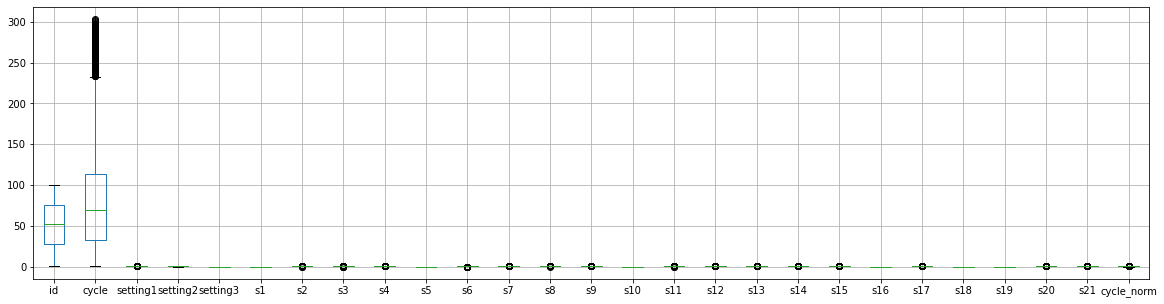

In [24]:
test_df.boxplot(figsize=(20, 5))

In [25]:
test_df.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,13096.0,13096.000000,13096.000000,13096.000000,13096.0,...,13096.000000,13096.000000,13096.000000,13096.0,13096.000000,13096.0,13096.0,13096.000000,13096.000000,13096.000000
mean,51.543907,76.836515,0.499358,0.503532,0.0,0.0,0.381051,0.371903,0.379564,0.0,...,0.280919,0.201299,0.388395,0.0,0.380969,0.0,0.0,0.583335,0.609697,0.210073
std,28.289423,53.057749,0.126591,0.245025,0.0,0.0,0.120753,0.109075,0.112902,0.0,...,0.083727,0.052578,0.111617,0.0,0.102798,0.0,0.0,0.109830,0.116156,0.146974
min,1.000000,1.000000,0.028736,0.000000,0.0,0.0,-0.024096,-0.043601,0.036124,0.0,...,0.014706,0.044174,0.030396,0.0,0.083333,0.0,0.0,0.131783,0.056890,0.000000
25%,28.000000,33.000000,0.413793,0.333333,0.0,0.0,0.297440,0.295618,0.298785,0.0,...,0.220588,0.167045,0.310504,0.0,0.333333,0.0,0.0,0.511628,0.534935,0.088643
50%,52.000000,69.000000,0.500000,0.500000,0.0,0.0,0.376506,0.369523,0.374578,0.0,...,0.279412,0.198421,0.384763,0.0,0.416667,0.0,0.0,0.589147,0.614471,0.188366
75%,76.000000,113.000000,0.586207,0.750000,0.0,0.0,0.460843,0.443046,0.452397,0.0,...,0.338235,0.229229,0.459407,0.0,0.416667,0.0,0.0,0.658915,0.689589,0.310249
max,100.000000,303.000000,0.948276,1.083333,0.0,0.0,0.930723,0.795945,0.862762,0.0,...,0.647059,0.622046,0.833013,0.0,0.750000,0.0,0.0,0.984496,1.032450,0.836565


The effective RUL of the test set is stored in the groud truth file.

In [26]:
# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

In [27]:
test_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.000000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.002770,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.005540,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.008310,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.011080,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.781609,0.500000,0.0,0.0,0.611446,0.619359,0.566172,0.0,...,0.584890,0.564063,0.0,0.500000,0.0,0.0,0.395349,0.418669,0.534626,24
13092,100,195,0.436782,0.416667,0.0,0.0,0.605422,0.537388,0.671843,0.0,...,0.572350,0.485956,0.0,0.583333,0.0,0.0,0.333333,0.528721,0.537396,23
13093,100,196,0.465517,0.250000,0.0,0.0,0.671687,0.482014,0.414754,0.0,...,0.605326,0.507888,0.0,0.583333,0.0,0.0,0.372093,0.429301,0.540166,22
13094,100,197,0.281609,0.583333,0.0,0.0,0.617470,0.522128,0.626435,0.0,...,0.622046,0.562524,0.0,0.583333,0.0,0.0,0.403101,0.518779,0.542936,21


# Training

In [28]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [30]:
# The sequence length is the number of time-series data the model takes as input
sequence_length = 50

# Feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 50, 25)


(15631, 1)

## LSTM

We can finally build the neural network.
The network has 2 LSTM, the first one with 100 units and the second with 50. Dropout is applied to both layers to control overfitting. The ouput layer is a Dense layer with just one unit.

In [32]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae'])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
__________________________________________________

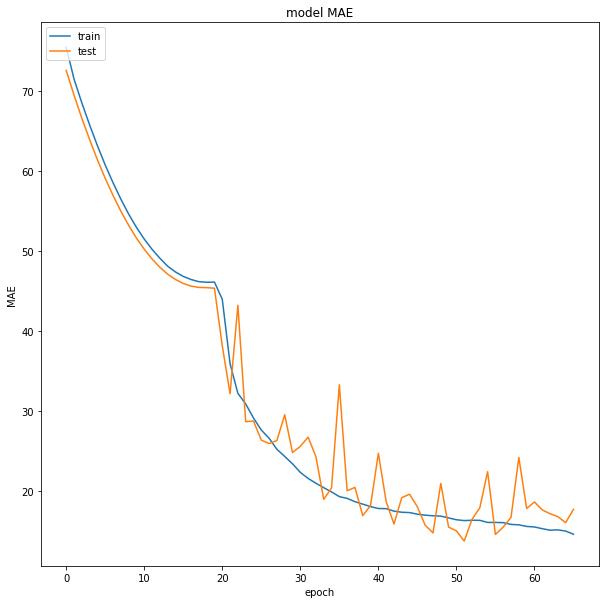

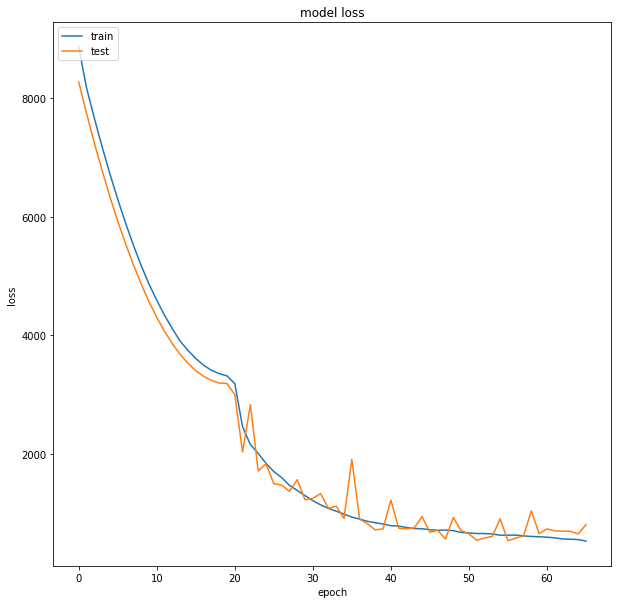

In [33]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

In [35]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[0]))
print('\nLOSS: {}'.format(scores[1]))

15631/15631 [==============================] - 5s 291us/step

MAE: 560.7542115821543

LOSS: 15.656268119812012


Let's load the model and evaluate the performance on the test set

In [ ]:
estimator = load_model(model_path)

# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('\nMAE: {}'.format(scores_test[0]))
print('\nLOSS: {}'.format(scores_test[1]))

y_pred_test = estimator.predict(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify.png")